In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_csv = pd.read_csv('./data.csv', usecols=[1])

In [3]:
data_csv.shape

(145, 1)

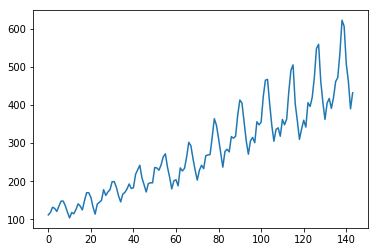

In [4]:
plt.plot(data_csv)

In [5]:
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [6]:
len(dataset)

144

In [7]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [8]:
data_X, data_Y = create_dataset(dataset, look_back=4)

In [9]:
print(data_X.shape)
print(data_Y.shape)

(140, 4, 1)
(140, 1)


In [10]:
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [11]:
import torch
# seq, batch=1, feature=2
train_X = train_X.reshape(-1, 1, 4)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 4)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [12]:
from torch import nn
from torch.autograd import Variable

In [13]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        seq, batch, hidden = x.shape
        x = x.view(seq*batch, hidden)
        x = self.reg(x)
        x = x.view(seq, batch, -1)
        return x

In [14]:
net = lstm_reg(4, 10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [15]:
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # forward
    out = net(var_x)
    loss = criterion(out, var_y)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # display
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e+1, loss.item()))

Epoch: 100, Loss: 0.00432
Epoch: 200, Loss: 0.00380
Epoch: 300, Loss: 0.00171
Epoch: 400, Loss: 0.00165
Epoch: 500, Loss: 0.00130
Epoch: 600, Loss: 0.00088
Epoch: 700, Loss: 0.00072
Epoch: 800, Loss: 0.00042
Epoch: 900, Loss: 0.00037
Epoch: 1000, Loss: 0.00032


In [16]:
net = net.eval()
data_X = data_X.reshape(-1, 1, 4)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data)

In [17]:
pred_test = pred_test.view(-1).data.numpy()

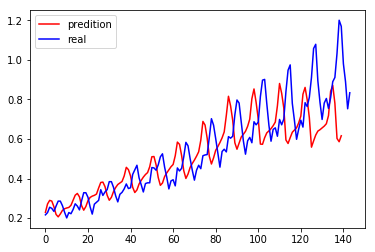

In [18]:
plt.plot(pred_test, 'r', label='predition')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')